**Quando si ha un dataset piccolo di immagini, un'approccio comune e molto efficiente è quello di utilizzare dei Modelli Pre-Addestrati.** Questo perchè i modelli pre-addestrati sono allenati su dataset molto grandi e con un gran numero di classi. Quindi, **si utilizza la conoscenza che ha il modello pre-addestrato per risolvere il nostro task**, anche se il nostro problema ha classi differenti rispetto a quelle sul quale si è allenato il modello. Infatti, **la portabilità delle feature imparate dai modelli è una dei principali vantaggi del Deep Learning.**

**Ci sono 2 modi per utilizzare un modello pre-addestrato:**
1. **Feature Extraction**
2. **Fine-Tuning**

**Feature Extraction consiste nell'utilizzare le rappresentazioni imparate da un modello pre-addestrato per estrarre feature interessanti sui nuovi samples, e, successivamente, darle in input a un nuovo classificatore, che viene allenato da 0 (from scratch).**

Più specificamente, **una CNN (Convnet) utilizzata per un task di image classification è composta da 2 parti:**
1. **(Prima Parte - Convulational Base)** Esse iniziano con una serie di Layer Convulazionali e di Pooling;
2. **(Seonda Parte)** Esse finiscono con un layer Denso che si occupa della classificazione.

**Fare feature Extraction consiste nel prendere la Convulational Base di un modello pre-trainato, dargli input i nuovi dati (dati del nostro problema) e successivamente allenare un nuovo classificatore.**

**Come mai si riutilizza solo la Base Convulazionale e non tutta la rete?**
1. Le rappresentazione imparate da questa parte di rete sono più generiche, e quindi, più riutilizzabili
2. Le rappresentazione dei Dense layer non hanno informazioni spaziali degli oggetti, questi layer infatti, eliminano la nozione di spazio, quindi, per problemi dove l'object position/location conta. questi layer sono inutili da riutilizzare.

NB: Una cosa importante sul discorso di generalità e di apprendimento delle feature è che il tutto dipende dalla profondità della rete. Generalmente,**i primi layer di una rete, sono in grado di apprendere ed estrarre i concetti più generici**. Quindi, se il nuovo dataset **differisce di tanto** dai dati sul quale si è allenato il modello, **piuttosto che utilizzare tutta la base convulazione, si potrebbero utilizzare solo i primi layer visto che si occupano delle feature generiche.**

In [ ]:
!unzip -qq train.zip

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]

    for fname in fnames:
      shutil.copyfile(src=original_dir / fname,
      dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


# **Modello**

In [ ]:
from tensorflow import keras

conv_base = keras.applications.vgg16.VGG16(
  weights="imagenet",
  include_top=False,
  input_shape=(180, 180, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Durante questo notebook utilizzeremo come Modello Pre-Addestrato il Modello VGG16, in quanto, contiene i classici layer di una Convnet, quindi è semplice comprendere la sua architettura.

Il modello è presente in Keras, e per caricarlo, si passano 3 argomenti al costruttore:


1.   **Weights**: specifica il checkpoint dei pesi per inizializzare il modello.
2.   **Include_top**: si riferisce se includere o no il Layer denso di classificazione del modello. In questo caso, visto che verrà definito e allenato da 0, non lo includiamo.
3. **input_shape**: si specifica la dimensione dei dati che verranno dati in input alla rete. Se non la si indica, la rete potrà prendere un input di una qualsiasi dimensione. Se si conosce la dimensione, meglio specificarla in modo che nel summary conosceremo l'output e input shapedi ogni layer.

**Vediamo l'archittetura del modello tramite il .summary()**



In [ ]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Il modello come detto prima, è composto solo dai classici layer di una ConvNet (**Convulazione e Pooling**).

**Il layer Denso non è stato incluso, infatti il modello termina con un layer di Max Pooling che restituisce una feature map con shape (5,5,512), che rappresenta la shape dei dati di input del nostro classificatore.**

A questo punto abbiamo 2 modi per procedere:


*  **Runnare la base convulazione (modello pre-addestrato) sul nostro dataset e memorizzare l'output come un'array numpy che verrà poi utilizzato per addestrare il nuovo classificatore denso.** Le immagini verranno viste solo una volta dalla base convulazionale **Questa tecnica però non permette di Fare Data Augmentation**. Questo perchè faremo solo l'allenamento del classificatore (Un layer denso), quindi non lavoriamo a livello di immagini, ma considerando la loro feature map.
*  **Estendere la Base Convulazione (conv_base) aggiugendo dei Dense Layer al top**, e runnare la rete per intero sui dati di input. **Questa tecnica permette di utilizzare Data Augmentation.**

**Partiamo con il primo modo**




# **Feature Extraction Without Data Augmentation**
Estrerremo le feature come un array NumPy chiamando il metodo .predict() del nostro modello conv_base **su tutto il dataset (training, validation e test set).**

Iteriamo sul nostro dataset per estrarre le VGG16 feature.

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
  all_features = []
  all_labels = []

  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

**il metodo .predict() si aspetta di ricevere solo delle immagini, ma il nostro dataset al momento restituisce batches di immagini con le loro label. Inoltre, il modello VGG16 si aspetta in input delle immagini preprocessate con la funzione keras.applications.vgg16.preprocess_input().**

In [ ]:
train_features.shape

(2000, 5, 5, 512)

Quindi adesso train_features rappresenta il training set del classificatore che andremo ad allenare per effettuare la classificazione. I dati sono stati ottenuti come output dal modello VGG16, quindi avranno una shape (5,5,512). D**i conseguenza, il classificatrore che andremo ad allenare riceverà in input dei dati con shape (5,5,512) (2.000 dati in totale).**

A questo punto possiamo definire il nostro classificatore densamente connesso e allenarlo sui dati appena ottenuti dal modello VGG16.

In [ ]:
from keras import layers

inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs) #Appiattiamo i dati perchè i dense layer lavorano solo su array (tensori 1D)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
  optimizer="rmsprop",
  metrics=["accuracy"])

callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")
]
history = model.fit(
  train_features, train_labels,
  epochs=20,
  validation_data=(val_features, val_labels),
  callbacks=callbacks)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8677 - loss: 38.3704 - val_accuracy: 0.9700 - val_loss: 2.9167
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9747 - loss: 3.4378 - val_accuracy: 0.9730 - val_loss: 3.1742
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9744 - loss: 4.0292 - val_accuracy: 0.9740 - val_loss: 3.1685
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9912 - loss: 0.7337 - val_accuracy: 0.9690 - val_loss: 3.7912
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9866 - loss: 1.2556 - val_accuracy: 0.9740 - val_loss: 3.3691
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9974 - loss: 0.2023 - val_accuracy: 0.9760 - val_loss: 3.8996
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9987 - loss: 0.0394 - val_accuracy: 0.9750 - val_loss: 3.6301
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9930 - loss: 1.1282 - val_accuracy: 0.9770 - val_los

**Utilizziamo il Droput per mitigare l'overfitting e la funzione sigmoide in quanto si tratta di una classificazione binaria.**

**L'allenamento è veloce perchè bisogna lavorare solo sue 2 Dense Layer.**

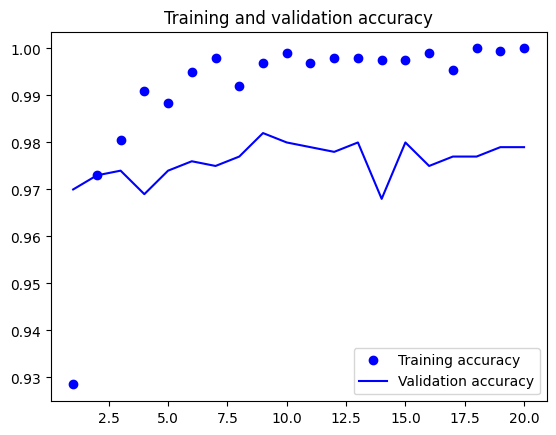

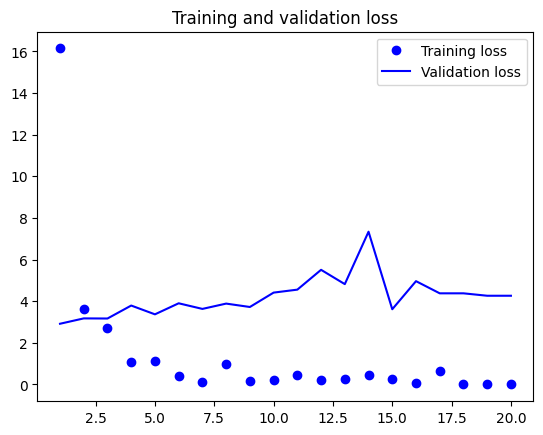

In [ ]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Il modello raggiunge una validation accurcay del circa 97%, **molto meglio rispetto quando lavoravano su una Convnet allenata da 0 (80% accuracy con Data Augmentation e 75% di accuracy senza).**

Un distacco così elevato è dovuto anche dal fatto che ImageNet contiene anche immagini di cani e gatti, quindi il modello pre-allenato ha già le conoscenze esatte per il task su cui stiamo lavorando.

**Tuttavia, il grafico mostra che il modello va comunque in overfitting** già dall'inizio, nonostante l'uso del Dropout con un rate alto. **Questo perchè non utilizziamo la Data Augmentantion**, che ricordiamo, è molto importante per evitare l'overfitting quando si lavora su dataset piccoli.

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")

test_loss, test_acc = test_model.evaluate(test_features, test_labels
                                          )
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9728 - loss: 3.4726
Test accuracy: 0.971


# **Feature extraction With Data Augmentation**

Passiamo alla seconda tecnica menzionata prima per fare feature Extraction, che è **più lenta e più costosa**, ma che permette l'utilizzo della data augmentation durante l'allenamento: **in questo caso si crea un nuovo modello che collega la conv_base (VGG16) con un nuovo classificatore e allenarlo in maniera end to end sull'input.**

Per far questo però, il primo step è quello di **freezare i pesi della conv_base in modo che non vengano modificati durante la fase di training** del nuovo modello. **Se questo non viene fatto, i pesi verranno modificati e tutto l'apprendimento della rete pre-addestrata verrà perso.**

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
  weights="imagenet",
  include_top=False)

conv_base.trainable = False

In keras, per freezare i pesi bisogna impostare l'attributo trainable del modello = false, così facendo, **la lista dei pesi trainabili si svuoterà, indicando che non ci sono pesi da allenare** e quindi, da cambiare durante l'allenamento del modello stesso.

Infatti, stampando la lunghezza della lista dei pesi trainabili, il risultato sarà = 0.

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights before freezing the conv base:", len(conv_base.trainable_weights))

conv_base.trainable = False
print("This is the number of trainable weights after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


Adesso possiamo creare il nostro modello che mette insieme:
1. Uno step di Data Augmentantion iniziale;
2. La base convulazione freezata del modello pre-addestrato (VGG16)
3. Un classificatore denso

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
  ])

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)

x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
  optimizer="rmsprop",
  metrics=["accuracy"])

**Con questo setup, solo i pesi dei due dense layer finali verranno allenati.**

Passiamo all'allenamento del modello, avendo aggiunto la data augmentation, **ci si aspetta che il modello vada in overfitting più avanti nelle epoche rispetto alla tecnica precedente, quindi aumentiamo le epoche a 50.**

In [ ]:
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction_with_data_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
]

history = model.fit(
  train_dataset,
  epochs=50,
  validation_data=validation_dataset,
  callbacks=callbacks)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 202ms/step - accuracy: 0.8255 - loss: 42.1059 - val_accuracy: 0.9650 - val_loss: 5.2255
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.9455 - loss: 6.9837 - val_accuracy: 0.9450 - val_loss: 11.5683
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.9501 - loss: 7.4243 - val_accuracy: 0.9590 - val_loss: 6.6152
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 178ms/step - accuracy: 0.9511 - loss: 7.8472 - val_accuracy: 0.9710 - val_loss: 6.5227
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 0.9690 - loss: 4.3159 - val_accuracy: 0.9720 - val_loss: 4.0684
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - accuracy: 0.9726 - loss: 3.0904 - val_accuracy: 0.9800 - val_loss: 4.5978
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - accuracy: 0.9736 - loss: 2.3342 - val_accuracy: 0.9710 - val_loss: 5.5589
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 0.9730 - loss: 3.4675 - val_accu

**Con questa soluzione, la validation accuracy è praticamente costante sul 97-98%, quindi, leggermente più alta rispetto prima.**

La differenza principale la si nota sul comportamento delle curve, infatti, in questa le soluzione, le curve non tendono ad aprirsi come successo in precedenza, dove, già dopo 2/3 epoche, si poteva notare il classico movimento a "forbice" che va ad indicare l'overfitting. Mentre in questo caso le curve vanno "insieme".

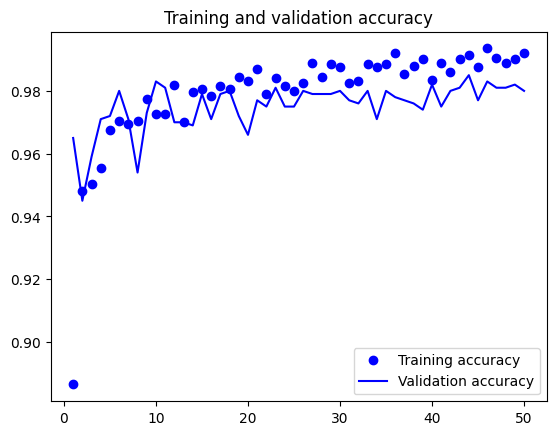

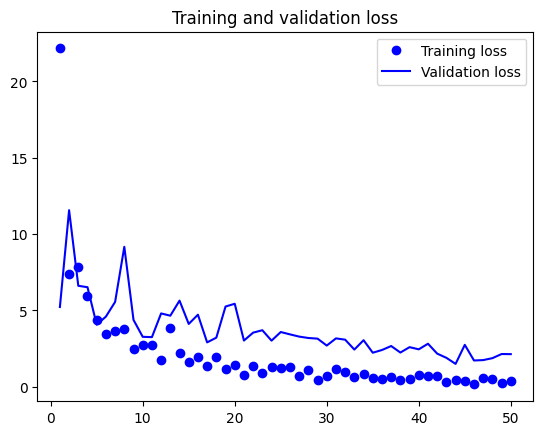

In [ ]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.keras")

test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.9779 - loss: 1.8820
Test accuracy: 0.979


Otteniamo Un'accuracy quasi del 98%, un piccolo miglioramento rispetto a prima, a fronte di un tempo di training più elevato e complesso.